In [1]:
import confirm.berrylib.util as util

util.setup_nb(pretty=False)

import time
from scipy.special import logit, expit
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import jax.numpy as jnp
import warnings
import confirm.berrylib.fast_inla as fast_inla
import confirm.imprint.binomial as binomial
import confirm.imprint.grid as grid
import confirm.imprint.execute as execute

import jax

In [2]:
def dots_plot(g, typeI_upper_bound, hob):
    plt.subplots(1, 2, figsize=(7, 3.0), constrained_layout=True)
    plt.subplot(1, 2, 1)
    plt.scatter(g.theta_tiles[:, 0], g.theta_tiles[:, 1], c=hob, s=10)
    plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.scatter(g.theta_tiles[:, 0], g.theta_tiles[:, 1], c=typeI_upper_bound, s=10)
    plt.colorbar()
    plt.show()


def dots_plot2(g, typeI_upper_bound, hob):
    plt.scatter(g.theta_tiles[:, 0], g.theta_tiles[:, 1], c=hob, s=10)
    plt.colorbar()

In [3]:
n_arms = 2
n_arm_samples = 35
fi = fast_inla.FastINLA(n_arms=n_arms, critical_value=0.99)
rejection_table = binomial.build_rejection_table(
    n_arms, n_arm_samples, fi.rejection_inference
)
accumulator = binomial.binomial_accumulator(
    lambda data: binomial.lookup_rejection(rejection_table, data[..., 0])
)

In [4]:
n_theta_1d = 4
theta_min = -3.5
theta_max = 1.0

null_hypos = [
    grid.HyperPlane(-np.identity(n_arms)[i], -logit(0.1)) for i in range(n_arms)
]
theta, radii = grid.cartesian_gridpts(
    np.full(n_arms, theta_min), np.full(n_arms, theta_max), np.full(n_arms, n_theta_1d)
)
g_raw = grid.build_grid(theta, radii)
start_grid = grid.prune(grid.intersect_grid(g_raw, null_hypos))

In [5]:
seed = 10

target_hob_cost = 0.001
target_hob_rel_bound = 0.3
target_sim_cost = 0.001
target_sim_rel_bound = 0.3
# N_max = int(2e5)

iter_max = 100

In [6]:
from rich import print as rprint

In [7]:
# plt.subplots(
#     iter_max // 3, 3, figsize=(10.0, 3.5 * iter_max / 3), constrained_layout=True
# )

A = execute.ada_setup(start_grid, n_initial_sims=5000, delta=0.01, holderq=6)
cur_bound = np.inf

report_history = []
for ada_i in range(iter_max):
    # np.random.seed(seed)
    start = time.time()
    old_total = A.total_sims
    A = execute.ada_simulate(A, accumulator, n_arm_samples)
    sim_runtime = time.time() - start
    assert np.all(A.sim_sizes == A.target_sim_sizes)

    # plt.subplot(iter_max // 3, 3, ada_i + 1)
    # dots_plot2(A.g, typeI_upper_bound, hob_upper)
    if ada_i == iter_max - 1:
        break

    typeI_upper_bound = A.typeI_est + A.typeI_CI
    cur_bound = np.max(A.hob_upper)
    worst_tile = np.argmax(A.hob_upper)
    should_refine = (
        A.hob_upper[worst_tile] - typeI_upper_bound[worst_tile]
        > typeI_upper_bound[worst_tile] - A.typeI_est[worst_tile]
    )

    hob_target_bound = np.max(typeI_upper_bound)
    hob_expensive = A.hob_upper > hob_target_bound + target_hob_cost
    hob_loose = (
        A.hob_upper - typeI_upper_bound
    ) / typeI_upper_bound > target_hob_rel_bound
    hob_tiny = A.hob_upper < 0.2 * hob_target_bound
    which_refine = hob_expensive | (hob_loose & (~hob_tiny))

    sim_target_bound = np.max(A.typeI_est)
    sim_expensive = typeI_upper_bound > sim_target_bound + target_sim_cost
    sim_loose = (typeI_upper_bound - A.typeI_est) / (
        A.typeI_est + 1e-9
    ) > target_sim_rel_bound
    sim_tiny = typeI_upper_bound < 0.2 * sim_target_bound
    more_sims = sim_expensive | (sim_loose & (~sim_tiny))

    report = dict(
        iter=ada_i,
        cur_bound=f"{cur_bound:.4f}",
        n_tiles=A.g.n_tiles,
        total_sims=A.total_sims,
        new_sims=f"{(A.total_sims - old_total) / 1000000:.1f}m",
        total_sims_so_far=f"{A.total_sims / 1000000:.1f}m",
    )

    # if (np.sum(which_refine) > 0) and (should_refine or np.sum(more_sims) == 0):
    A.target_sim_sizes[more_sims] *= 2
    report["n_add_sims"] = np.sum(more_sims)
    report["n_add_sims_because_expensive"] = np.sum(sim_expensive)
    report["n_add_sims_because_loose"] = np.sum(sim_loose & (~sim_tiny))

    A, did_refine = execute.ada_refine(A, which_refine)
    report["n_refined"] = np.sum(which_refine)
    report["n_refined_because_expensive"] = np.sum(hob_expensive)
    report["n_refined_because_loose"] = np.sum(hob_loose & (~hob_tiny))
    # elif np.sum(more_sims) > 0:
    # A.target_sim_sizes[more_sims] += 5000
    if np.sum(which_refine) == 0 and np.sum(more_sims) == 0:
        print("done after", ada_i, "iterations")
        break

    report["simulation_runtime"] = f"{sim_runtime:.2f}s"
    report["iteration_runtime"] = f"{time.time() - start:.2f}s"
    rprint(report)
    report_history.append(report)

# plt.show()

{
    'iter': 0,
    'cur_bound': '14.0176',
    'n_tiles': 16,
    'total_sims': 80000,
    'new_sims': '0.1m',
    'total_sims_so_far': '0.1m',
    'n_add_sims': 2,
    'n_add_sims_because_expensive': 2,
    'n_add_sims_because_loose': 0,
    'n_refined': 16,
    'n_refined_because_expensive': 16,
    'n_refined_because_loose': 16,
    'simulation_runtime': '0.80s',
    'iteration_runtime': '0.87s'
}

{
    'iter': 1,
    'cur_bound': '1.3553',
    'n_tiles': 67,
    'total_sims': 430000,
    'new_sims': '0.3m',
    'total_sims_so_far': '0.4m',
    'n_add_sims': 2,
    'n_add_sims_because_expensive': 2,
    'n_add_sims_because_loose': 0,
    'n_refined': 67,
    'n_refined_because_expensive': 53,
    'n_refined_because_loose': 67,
    'simulation_runtime': '0.49s',
    'iteration_runtime': '0.56s'
}

{
    'iter': 2,
    'cur_bound': '0.2705',
    'n_tiles': 281,
    'total_sims': 1883750,
    'new_sims': '1.5m',
    'total_sims_so_far': '1.9m',
    'n_add_sims': 61,
    'n_add_sims_because_expensive': 3,
    'n_add_sims_because_loose': 58,
    'n_refined': 230,
    'n_refined_because_expensive': 78,
    'n_refined_because_loose': 230,
    'simulation_runtime': '1.04s',
    'iteration_runtime': '1.11s'
}

{
    'iter': 3,
    'cur_bound': '0.1499',
    'n_tiles': 1135,
    'total_sims': 9387500,
    'new_sims': '7.5m',
    'total_sims_so_far': '9.4m',
    'n_add_sims': 23,
    'n_add_sims_because_expensive': 8,
    'n_add_sims_because_loose': 15,
    'n_refined': 624,
    'n_refined_because_expensive': 76,
    'n_refined_because_loose': 624,
    'simulation_runtime': '2.15s',
    'iteration_runtime': '2.22s'
}

{
    'iter': 4,
    'cur_bound': '0.0868',
    'n_tiles': 3200,
    'total_sims': 32388076,
    'new_sims': '23.0m',
    'total_sims_so_far': '32.4m',
    'n_add_sims': 103,
    'n_add_sims_because_expensive': 17,
    'n_add_sims_because_loose': 86,
    'n_refined': 2156,
    'n_refined_because_expensive': 93,
    'n_refined_because_loose': 2156,
    'simulation_runtime': '6.12s',
    'iteration_runtime': '6.20s'
}

{
    'iter': 5,
    'cur_bound': '0.0750',
    'n_tiles': 11240,
    'total_sims': 129579264,
    'new_sims': '97.2m',
    'total_sims_so_far': '129.6m',
    'n_add_sims': 85,
    'n_add_sims_because_expensive': 29,
    'n_add_sims_because_loose': 56,
    'n_refined': 722,
    'n_refined_because_expensive': 121,
    'n_refined_because_loose': 601,
    'simulation_runtime': '18.61s',
    'iteration_runtime': '18.68s'
}

{
    'iter': 6,
    'cur_bound': '0.0655',
    'n_tiles': 13254,
    'total_sims': 163719454,
    'new_sims': '34.1m',
    'total_sims_so_far': '163.7m',
    'n_add_sims': 108,
    'n_add_sims_because_expensive': 18,
    'n_add_sims_because_loose': 90,
    'n_refined': 152,
    'n_refined_because_expensive': 136,
    'n_refined_because_loose': 16,
    'simulation_runtime': '33.92s',
    'iteration_runtime': '33.99s'
}

{
    'iter': 7,
    'cur_bound': '0.0608',
    'n_tiles': 13502,
    'total_sims': 180692457,
    'new_sims': '17.0m',
    'total_sims_so_far': '180.7m',
    'n_add_sims': 86,
    'n_add_sims_because_expensive': 59,
    'n_add_sims_because_loose': 27,
    'n_refined': 194,
    'n_refined_because_expensive': 182,
    'n_refined_because_loose': 12,
    'simulation_runtime': '26.62s',
    'iteration_runtime': '26.69s'
}

{
    'iter': 8,
    'cur_bound': '0.0589',
    'n_tiles': 13812,
    'total_sims': 210256713,
    'new_sims': '29.6m',
    'total_sims_so_far': '210.3m',
    'n_add_sims': 139,
    'n_add_sims_because_expensive': 121,
    'n_add_sims_because_loose': 18,
    'n_refined': 113,
    'n_refined_because_expensive': 104,
    'n_refined_because_loose': 9,
    'simulation_runtime': '37.66s',
    'iteration_runtime': '37.74s'
}

{
    'iter': 9,
    'cur_bound': '0.0577',
    'n_tiles': 14061,
    'total_sims': 230644352,
    'new_sims': '20.4m',
    'total_sims_so_far': '230.6m',
    'n_add_sims': 86,
    'n_add_sims_because_expensive': 79,
    'n_add_sims_because_loose': 7,
    'n_refined': 134,
    'n_refined_because_expensive': 116,
    'n_refined_because_loose': 18,
    'simulation_runtime': '35.93s',
    'iteration_runtime': '36.00s'
}

{
    'iter': 10,
    'cur_bound': '0.0579',
    'n_tiles': 14411,
    'total_sims': 259889872,
    'new_sims': '29.2m',
    'total_sims_so_far': '259.9m',
    'n_add_sims': 25,
    'n_add_sims_because_expensive': 22,
    'n_add_sims_because_loose': 3,
    'n_refined': 4,
    'n_refined_because_expensive': 4,
    'n_refined_because_loose': 0,
    'simulation_runtime': '42.86s',
    'iteration_runtime': '42.93s'
}

{
    'iter': 11,
    'cur_bound': '0.0569',
    'n_tiles': 14417,
    'total_sims': 262528902,
    'new_sims': '2.6m',
    'total_sims_so_far': '262.5m',
    'n_add_sims': 27,
    'n_add_sims_because_expensive': 18,
    'n_add_sims_because_loose': 9,
    'n_refined': 356,
    'n_refined_because_expensive': 330,
    'n_refined_because_loose': 26,
    'simulation_runtime': '2.77s',
    'iteration_runtime': '2.84s'
}

{
    'iter': 12,
    'cur_bound': '0.0573',
    'n_tiles': 15223,
    'total_sims': 336251816,
    'new_sims': '73.7m',
    'total_sims_so_far': '336.3m',
    'n_add_sims': 20,
    'n_add_sims_because_expensive': 20,
    'n_add_sims_because_loose': 0,
    'n_refined': 13,
    'n_refined_because_expensive': 5,
    'n_refined_because_loose': 8,
    'simulation_runtime': '80.06s',
    'iteration_runtime': '80.12s'
}

{
    'iter': 13,
    'cur_bound': '0.0564',
    'n_tiles': 15260,
    'total_sims': 339508828,
    'new_sims': '3.3m',
    'total_sims_so_far': '339.5m',
    'n_add_sims': 25,
    'n_add_sims_because_expensive': 25,
    'n_add_sims_because_loose': 0,
    'n_refined': 4,
    'n_refined_because_expensive': 4,
    'n_refined_because_loose': 0,
    'simulation_runtime': '2.70s',
    'iteration_runtime': '2.71s'
}

{
    'iter': 14,
    'cur_bound': '0.0558',
    'n_tiles': 15266,
    'total_sims': 344239801,
    'new_sims': '4.7m',
    'total_sims_so_far': '344.2m',
    'n_add_sims': 12,
    'n_add_sims_because_expensive': 12,
    'n_add_sims_because_loose': 0,
    'n_refined': 0,
    'n_refined_because_expensive': 0,
    'n_refined_because_loose': 0,
    'simulation_runtime': '3.50s',
    'iteration_runtime': '3.50s'
}

{
    'iter': 15,
    'cur_bound': '0.0558',
    'n_tiles': 15266,
    'total_sims': 346644023,
    'new_sims': '2.4m',
    'total_sims_so_far': '346.6m',
    'n_add_sims': 11,
    'n_add_sims_because_expensive': 11,
    'n_add_sims_because_loose': 0,
    'n_refined': 0,
    'n_refined_because_expensive': 0,
    'n_refined_because_loose': 0,
    'simulation_runtime': '1.61s',
    'iteration_runtime': '1.61s'
}

{
    'iter': 16,
    'cur_bound': '0.0558',
    'n_tiles': 15266,
    'total_sims': 348637011,
    'new_sims': '2.0m',
    'total_sims_so_far': '348.6m',
    'n_add_sims': 9,
    'n_add_sims_because_expensive': 9,
    'n_add_sims_because_loose': 0,
    'n_refined': 27,
    'n_refined_because_expensive': 27,
    'n_refined_because_loose': 0,
    'simulation_runtime': '1.37s',
    'iteration_runtime': '1.44s'
}

{
    'iter': 17,
    'cur_bound': '0.0566',
    'n_tiles': 15317,
    'total_sims': 357245143,
    'new_sims': '8.6m',
    'total_sims_so_far': '357.2m',
    'n_add_sims': 3,
    'n_add_sims_because_expensive': 3,
    'n_add_sims_because_loose': 0,
    'n_refined': 2,
    'n_refined_because_expensive': 2,
    'n_refined_because_loose': 0,
    'simulation_runtime': '8.68s',
    'iteration_runtime': '8.73s'
}

{
    'iter': 18,
    'cur_bound': '0.0557',
    'n_tiles': 15323,
    'total_sims': 357988021,
    'new_sims': '0.7m',
    'total_sims_so_far': '358.0m',
    'n_add_sims': 2,
    'n_add_sims_because_expensive': 2,
    'n_add_sims_because_loose': 0,
    'n_refined': 0,
    'n_refined_because_expensive': 0,
    'n_refined_because_loose': 0,
    'simulation_runtime': '1.35s',
    'iteration_runtime': '1.35s'
}

done after 19 iterations


In [13]:
n_arms = 4
n_arm_samples = 100
ys = np.arange(n_arm_samples + 1)
Ygrids = np.stack(np.meshgrid(*[ys] * n_arms, indexing="ij"), axis=-1)
Yravel = Ygrids.reshape((-1, n_arms))

# 2. Sort the grid arms while tracking the sorting order so that we can
# unsort later.
colsortidx = np.argsort(Yravel, axis=-1)
inverse_colsortidx = np.zeros(Yravel.shape, dtype=np.int32)
axis0 = np.arange(Yravel.shape[0])[:, None]
inverse_colsortidx[axis0, colsortidx] = np.arange(n_arms)
Y_colsorted = Yravel[axis0, colsortidx]

# 3. Identify the unique datasets. In a 35^4 grid, this will be about 80k
# datasets instead of 1.7m.
Y_unique, inverse_unique = np.unique(Y_colsorted, axis=0, return_inverse=True)
(n_arm_samples**n_arms), Y_unique.shape

(100000000, (4598126, 4))

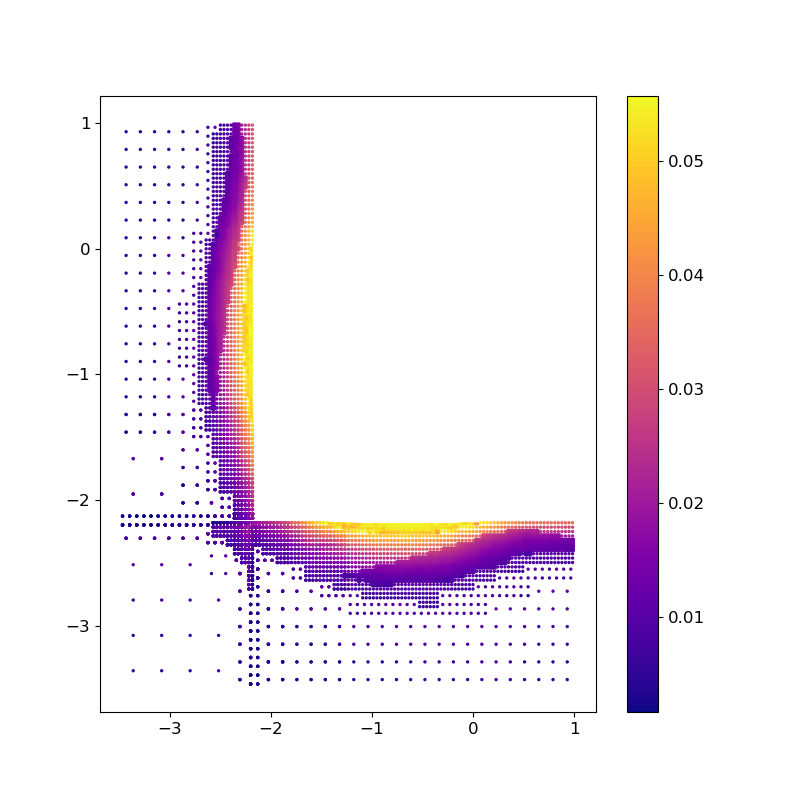

In [8]:
%matplotlib widget
plt.figure(figsize=(8, 8))
plt.scatter(A.g.theta_tiles[:, 0], A.g.theta_tiles[:, 1], c=A.hob_upper, s=2)
plt.colorbar()
plt.show()
# plt.figure(figsize=(20,20))
# plt.scatter(A.g.theta_tiles[:,0], A.g.theta_tiles[:, 1], c=np.log10(A.sim_sizes), s=2)
# plt.colorbar()
# plt.show()

In [9]:
def optimal_centering(f, p):
    return 1 / (1 + ((1 - f) / f) ** (1 / (p - 1)))

In [13]:
optimal_centering(np.linspace(0.001, 1, 100), 1.2)

array([1.00501504e-15, 1.77440961e-10, 4.74576291e-09, 3.50607449e-08, 1.49562941e-07,
       4.69707819e-07, 1.21314631e-06, 2.73574660e-06, 5.58436990e-06, 1.05626975e-05,
       1.88128661e-05, 3.19162180e-05, 5.20171214e-05, 8.19745950e-05, 1.25547381e-04,
       1.87619190e-04, 2.74472090e-04, 3.94117471e-04, 5.56695689e-04, 7.74957321e-04,
       1.06484109e-03, 1.44616561e-03, 1.94345446e-03, 2.58691590e-03, 3.41360037e-03,
       4.46875928e-03, 5.80742749e-03, 7.49624791e-03, 9.61554822e-03, 1.22616645e-02,
       1.55494819e-02, 1.96151250e-02, 2.46186731e-02, 3.07466977e-02, 3.82143126e-02,
       4.72662894e-02, 5.81766266e-02, 7.12457837e-02, 8.67946222e-02, 1.05154001e-01,
       1.26649019e-01, 1.51577198e-01, 1.80180564e-01, 2.12612711e-01, 2.48903446e-01,
       2.88925389e-01, 3.32368400e-01, 3.78728352e-01, 4.27315845e-01, 4.77287742e-01,
       5.27700019e-01, 5.77575706e-01, 6.25977922e-01, 6.72076721e-01, 7.15200035e-01,
       7.54862930e-01, 7.90774163e-01, 8.22

In [16]:
A.sim_sizes.max(), (4.5 / A.g.radii.min()) ** 2

(400000, 16777216.0)

In [18]:
(4.5 / A.g.radii.min()) ** 2 * A.sim_sizes.max() / 1e9, A.total_sims / 1e9

(6710.8864, 0.306004755)

In [21]:
hob_cost = np.max(A.hob_upper) - np.max(typeI_upper_bound)
sim_cost = np.max(typeI_upper_bound) - np.max(A.typeI_est)
hob_cost, sim_cost

(0.0009334792926380883, 0.0009915550360346803)